In [1]:
%matplotlib inline
import seaborn
import numpy, scipy, matplotlib.pyplot as plt, IPython.display as ipd
import librosa, librosa.display
plt.rcParams['figure.figsize'] = (13, 5)

[&larr; Back to Index](index.html)

# Onset-based Segmentation with Backtracking

[`librosa.onset.onset_detect`](http://librosa.github.io/librosa/generated/librosa.onset.onset_detect.html#librosa.onset.onset_detect) works by finding peaks in a spectral novelty function. However, these peaks may not actually coincide with the initial rise in energy or how we perceive the beginning of a musical note.

The optional keyword parameter `backtrack=True` will backtrack from each peak to a preceding local minimum. Backtracking can be useful for finding segmentation points such that the onset occurs shortly after the beginning of the segment. We will use `backtrack=True` to perform onset-based segmentation of a signal.

Load an audio file into the NumPy array `x` and sampling rate `sr`. 

In [2]:
x, sr = librosa.load('audio/classic_rock_beat.wav')
print(x.shape, sr)

(151521,) 22050


Listen:

In [3]:
ipd.Audio(x, rate=sr)

Compute the frame indices for estimated onsets in a signal:

In [4]:
hop_length = 512
onset_frames = librosa.onset.onset_detect(y=x, sr=sr, hop_length=hop_length)
print(onset_frames) # frame numbers of estimated onsets

[ 20  29  38  57  66  75  84  93 103 112 121 131 140 149 158 167 176 185
 196 204 213 232 241 250 260 269 278 288]


Convert onsets to units of seconds:

In [5]:
onset_times = librosa.frames_to_time(onset_frames, sr=sr, hop_length=hop_length)
print(onset_times)

[0.46439909 0.67337868 0.88235828 1.32353741 1.53251701 1.7414966
 1.95047619 2.15945578 2.39165533 2.60063492 2.80961451 3.04181406
 3.25079365 3.45977324 3.66875283 3.87773243 4.08671202 4.29569161
 4.55111111 4.73687075 4.94585034 5.38702948 5.59600907 5.80498866
 6.03718821 6.2461678  6.45514739 6.68734694]


Convert onsets to units of samples:

In [6]:
onset_samples = librosa.frames_to_samples(onset_frames, hop_length=hop_length)
print(onset_samples)

[ 10240  14848  19456  29184  33792  38400  43008  47616  52736  57344
  61952  67072  71680  76288  80896  85504  90112  94720 100352 104448
 109056 118784 123392 128000 133120 137728 142336 147456]


Plot the onsets on top of a spectrogram of the audio:

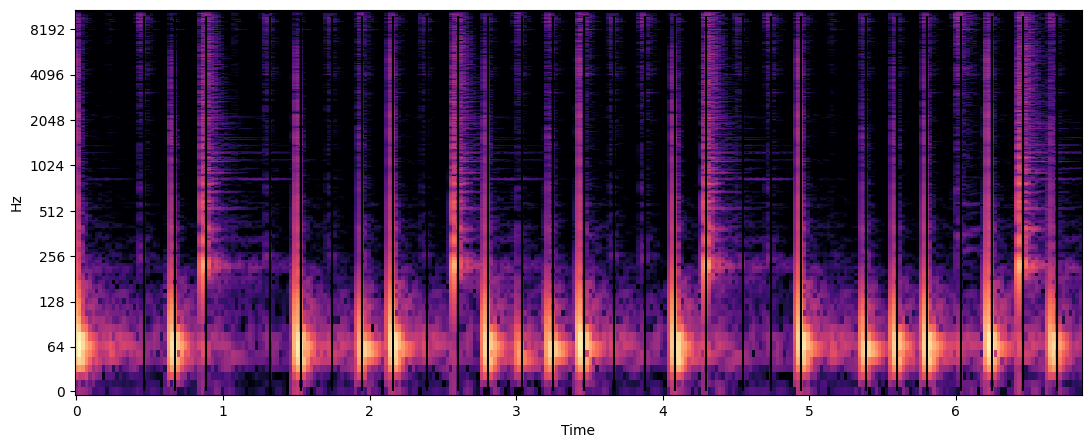

In [7]:
S = librosa.stft(x)
logS = librosa.amplitude_to_db(numpy.abs(S))
librosa.display.specshow(logS, sr=sr, x_axis='time', y_axis='log')
plt.vlines(onset_times, 0, 10000, color='k');

As we see in the spectrogram, the detected onsets seem to occur a bit before the actual rise in energy.

Let's listen to these segments. We will create a function to do the following:

1.  Divide the signal into segments beginning at each detected onset.
2.  Pad each segment with 500 ms of silence.
3.  Concatenate the padded segments.

In [8]:
def concatenate_segments(x, onset_samples, pad_duration=0.500):
    """Concatenate segments into one signal."""
    silence = numpy.zeros(int(pad_duration*sr)) # silence
    frame_sz = min(numpy.diff(onset_samples))   # every segment has uniform frame size
    return numpy.concatenate([
        numpy.concatenate([x[i:i+frame_sz], silence]) # pad segment with silence
        for i in onset_samples
    ])

Concatenate the segments:

In [9]:
concatenated_signal = concatenate_segments(x, onset_samples, 0.500)

Listen to the concatenated signal:

In [10]:
ipd.Audio(concatenated_signal, rate=sr)

As we hear, the little glitch between segments occurs because the segment boundaries occur during the attack, not before the attack.

## `librosa.onset.onset_backtrack`

We can avoid this glitch by backtracking from the detected onsets. 

When setting the parameter `backtrack=True`, `librosa.onset.onset_detect` will call [`librosa.onset.onset_backtrack`](http://librosa.github.io/librosa/generated/librosa.onset.onset_backtrack.html).
 For each detected onset, `librosa.onset.onset_backtrack` searches backward for a local minimum.

In [11]:
onset_frames = librosa.onset.onset_detect(y=x, sr=sr, hop_length=hop_length, backtrack=True)

Convert onsets to units of seconds:

In [12]:
onset_times = librosa.frames_to_time(onset_frames, sr=sr, hop_length=hop_length)

Convert onsets to units of samples:

In [13]:
onset_samples = librosa.frames_to_samples(onset_frames, hop_length=hop_length)

Plot the onsets on top of a spectrogram of the audio:

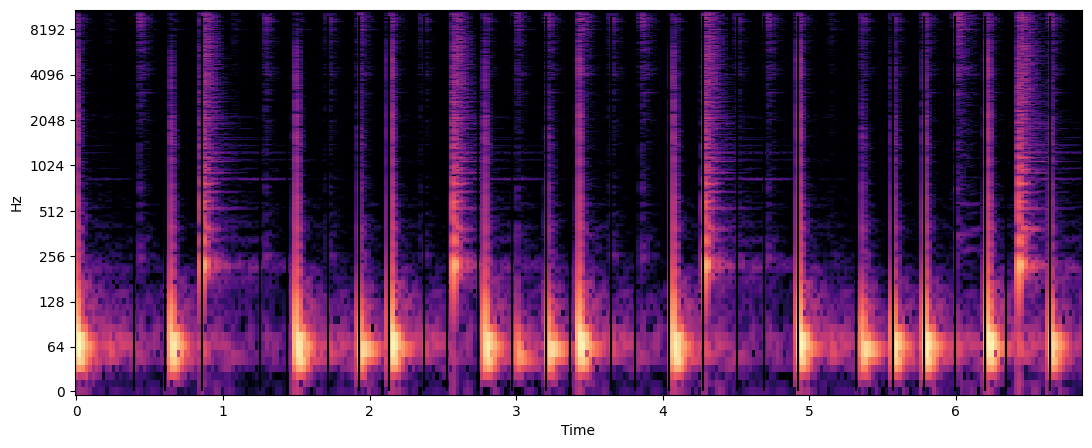

In [14]:
S = librosa.stft(x)
logS = librosa.amplitude_to_db(numpy.abs(S))
librosa.display.specshow(logS, sr=sr, x_axis='time', y_axis='log')
plt.vlines(onset_times, 0, 10000, color='k');

Notice how the vertical lines denoting each segment boundary appears before each rise in energy.

Concatenate the segments:

In [15]:
concatenated_signal = concatenate_segments(x, onset_samples, 0.500)

Listen to the concatenated signal:

In [16]:
ipd.Audio(concatenated_signal, rate=sr)

While listening, notice now the segments are perfectly segmented.

## Questions

Try with other audio files:

In [17]:
ls audio

125_bounce.wav                  jangle_pop.mp3
58bpm.wav                       latin_groove.mp3
README.md                       oboe_c6.wav
brahms_hungarian_dance_5.mp3    prelude_cmaj.wav
busta_rhymes_hits_for_days.mp3  simple_loop.wav
c_strum.wav                     simple_piano.wav
clarinet_c6.wav                 sir_duke_piano_fast.mp3
classic_rock_beat.mp3           sir_duke_piano_slow.mp3
classic_rock_beat.wav           sir_duke_trumpet_fast.mp3
conga_groove.wav                sir_duke_trumpet_slow.mp3
cowbell.wav                     thx_original.mp3
drum_samples/                   tone_440.wav
funk_groove.mp3


[&larr; Back to Index](index.html)